# Simulations - 1 

In [443]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 30)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"

In [466]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <- 800
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.iters <- 10

offset = 0.1
lambda = 1

In [467]:
GetInitPars <- function(train, q=0.6) {
    index = train$reward > quantile(train$reward, q) 
    rqmodel = rq(train$treatment[index] ~ train$covariates[index,] - 1, tau=.5, 
             method="lasso", weights=train$reward[index], lambda = lambda)
    return(coef(rqmodel))
}

In [488]:
global.stat <- list()
for (i in seq(1,number.of.iters)) {
    train <- GetSimulationData(sample.size, number.of.covariates)
    test <- GetSimulationData(test.data.sample.size, number.of.covariates)
    init.pars = GetInitPars(train)

    opt.params = list("opt.func"=DCOptimizeWithMML2Penalized, "approximation.eps"=1e-5, "tolerance"=1e-7, "init.pars"=init.pars)
    pars.dca.MM.approx <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    opt.params = list("opt.func"=DCOptimizeWithMML2Penalized, "tolerance"=1e-7, "init.pars"=init.pars)
    pars.dca.MM <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    opt.params = list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars)
    pars.dca.true.MM <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    pars.dca.l1 <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt.hyperparams=list("opt.func"=DCOptimizeL1Penalized, "init.pars"=init.pars))
    pars.gen.sa <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt.hyperparams=list("obj.func"=ObjectiveFunction, "init.pars"=init.pars))    
    pars.owl <- GetOwlParams(train, lambda)

    
    opt.decision <- c(1, 0.5, 0.5 , rep(0, length(pars.dca.MM) - 3))
    data.list <- list("train"=train, "test"=test)
    params.list  <- list("MM"=pars.dca.MM, "MM.appr"=pars.dca.MM.approx, "MM.proper.iters"=pars.dca.true.MM, 
                         "Lasso"=pars.dca.l1, 
                         "SimAnn"=pars.gen.sa, 
                         "Ideal"=opt.decision, "OWL"=pars.owl) 
    iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
    global.stat  <- rbind(global.stat, iter.stat)
}

MM converged after  1  iterations
MML2PenalizedProperIters Converged after  2  iterations
Converged after  4  iterations
Initializing par with random data inside bounds
It: 1, obj value: -23.24977049
It: 330, obj value: -25.15932392
It: 882, obj value: -25.32094046
It: 1, obj value: -25.32315132
.............It: 1, obj value: -25.3235031
..........
It: 311, obj value: -25.56899899
.
It: 342, obj value: -25.88395426
.
It: 373, obj value: -25.90110603
.
It: 404, obj value: -25.90275264
.
It: 435, obj value: -25.90471469
.
It: 466, obj value: -25.90567028
.
It: 497, obj value: -25.90595193
.
It: 528, obj value: -25.90686822
..
It: 590, obj value: -25.90733793
.
It: 621, obj value: -25.90750072
.
It: 652, obj value: -25.90753733
.
It: 683, obj value: -25.90754075
.
It: 714, obj value: -25.90754204
.
It: 745, obj value: -25.90765821
.
It: 776, obj value: -25.90773629
.
It: 807, obj value: -25.90773691
.
It: 838, obj value: -25.9082816
.
It: 869, obj value: -25.90847917
.
It: 900, obj value:

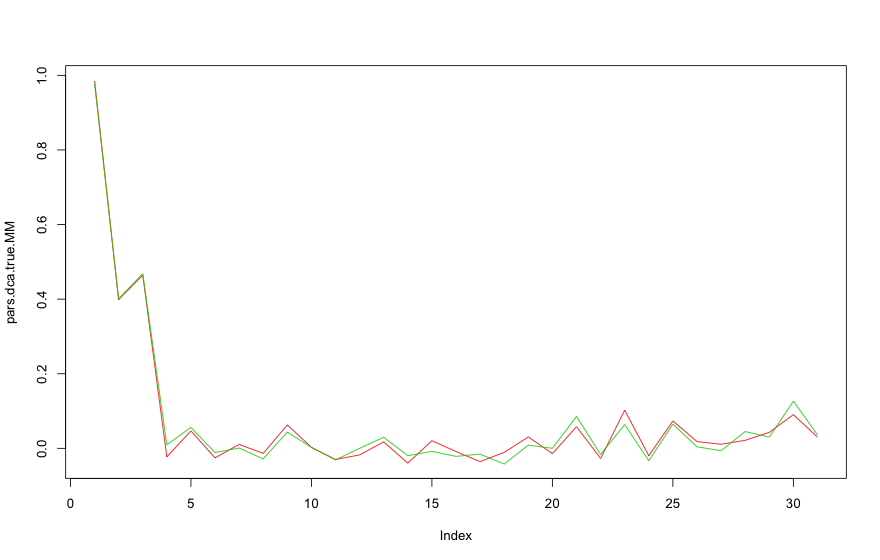

In [484]:
plot(pars.dca.true.MM, col=2, type="l")
lines(pars.owl, col=3)

In [471]:
melt = reshape::melt
gl.stat.df <- apply(global.stat, 2, unlist)
vf.train <- melt(gl.stat.df[, grep("VF.*TRAIN", colnames(gl.stat.df))])
vf.test <- melt(gl.stat.df[, grep("VF.*TEST", colnames(gl.stat.df))])
obj.train <- melt(gl.stat.df[, grep("OBJ.*TRAIN", colnames(gl.stat.df))])
obj.test <- melt(gl.stat.df[, grep("OBJ.*TEST", colnames(gl.stat.df))])
q.train <- melt(gl.stat.df[, grep("Q.*TRAIN", colnames(gl.stat.df))])
q.test <- melt(gl.stat.df[, grep("Q.*TEST", colnames(gl.stat.df))])

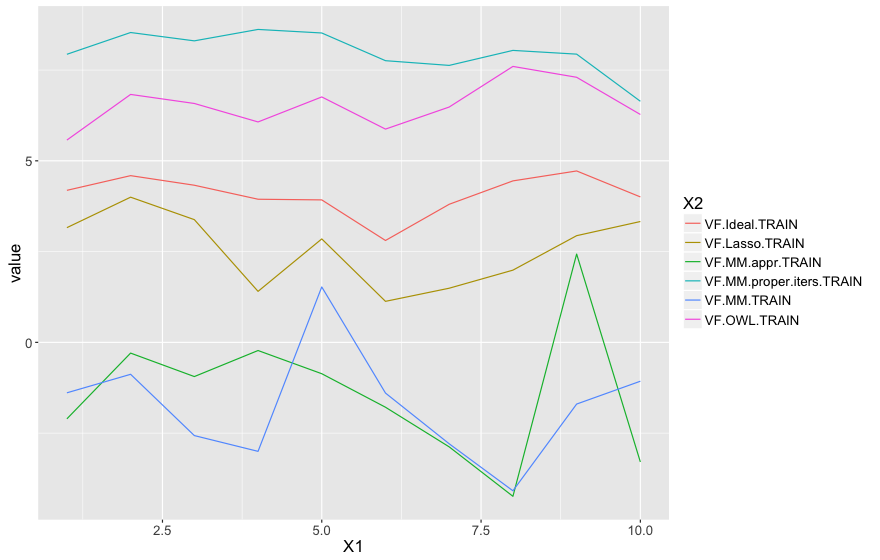

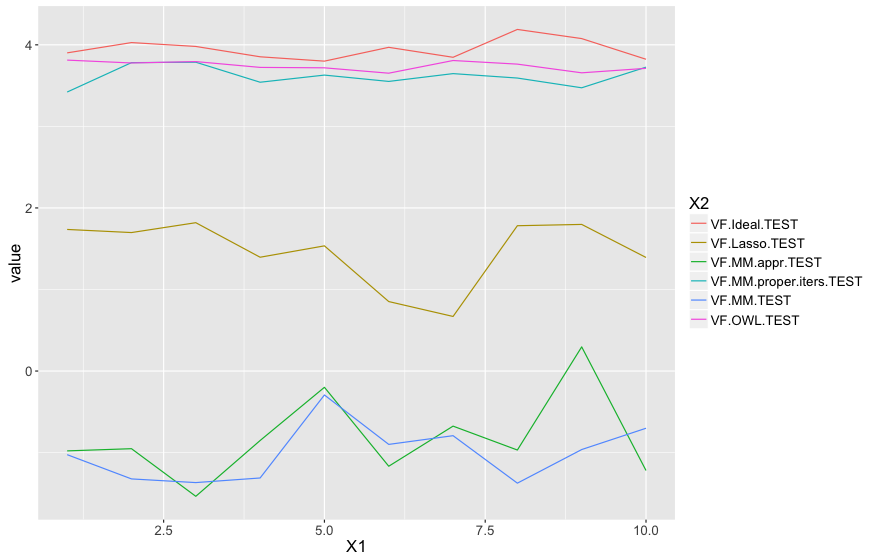

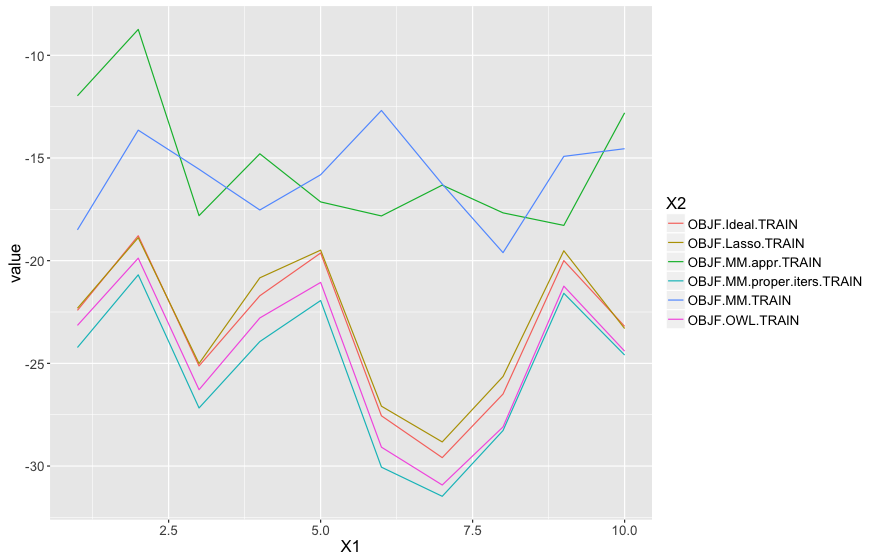

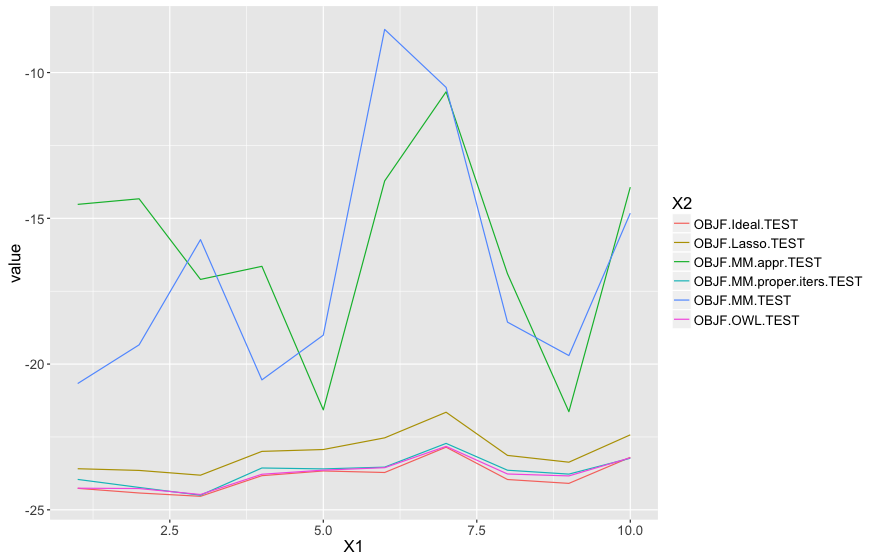

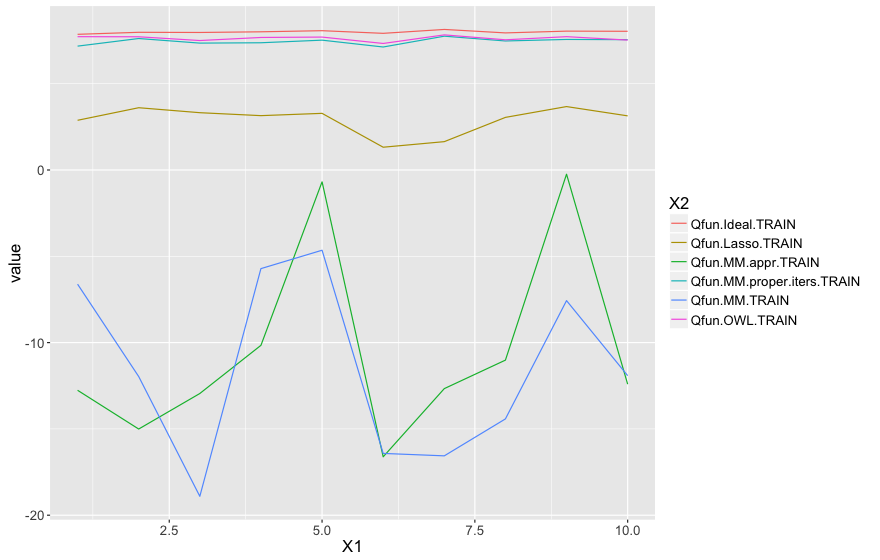

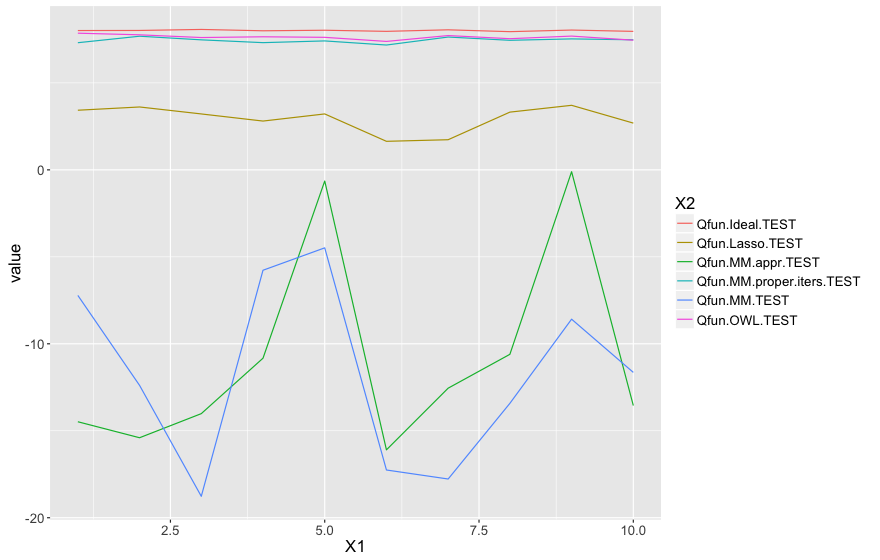

In [489]:
ggplot(vf.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(vf.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(obj.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(obj.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.train , aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))

In [461]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
data.list <- list("train"=train, "test"=test)

quants = seq(0.05, 0.99, 0.01)
stat = list()
for (q in quants) {
    pars.owl <- GetOwlParams(train, lambda, q = q)  
    s = GetMetricsForParams(list("OWL"=pars.owl), data.list, offset, PolicyFunLinearKernel, lambda)
    stat = rbind(stat, s)
}
s = data.frame(quantile=quants,  stat)

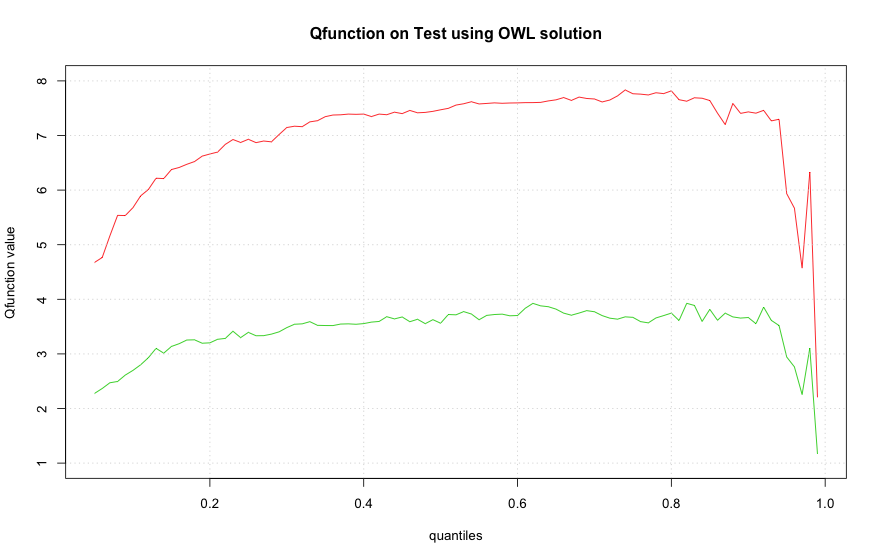

In [462]:
plot(quants, unlist(s[, "Qfun.OWL.TEST"]), type="l", ylim=c(1,8), col=2, xlab="", ylab="")
lines(quants, unlist(s[, "VF.OWL.TEST"]), type="l", col=3)
title("Qfunction on Test using OWL solution", xlab = "quantiles", ylab="Qfunction value")
grid()

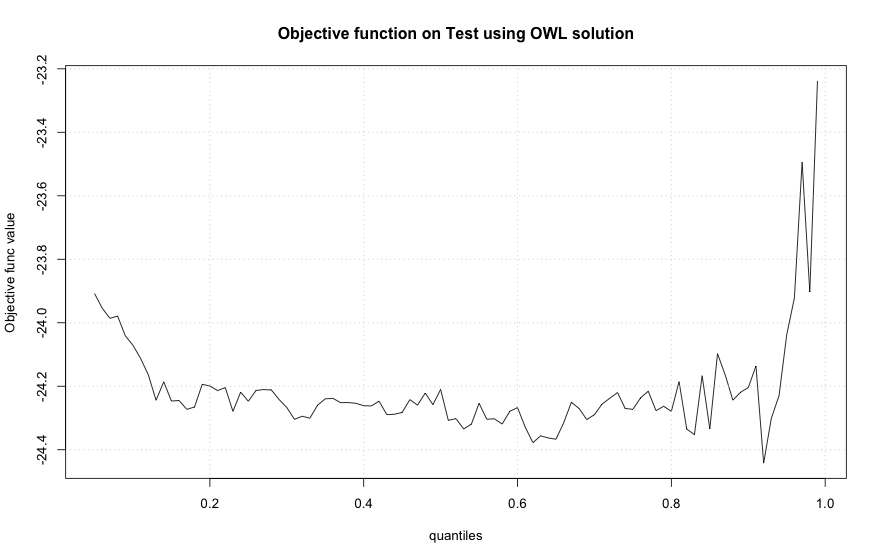

In [463]:
plot(quants, unlist(s[, "OBJF.OWL.TEST"]), type="l", xlab = "quantiles", ylab="Objective func value")
title("Objective function on Test using OWL solution")
grid()

Видно, что Kosorok взял квантиль, который очень близко к тому, который доставляет максимум Qfuncion.

In [464]:
s[which.max( unlist(s[, "VF.OWL.TEST"])), ]

,quantile,VF.OWL.TRAIN,OBJF.OWL.TRAIN,Qfun.OWL.TRAIN,VF.OWL.TEST,OBJF.OWL.TEST,Qfun.OWL.TEST
78,0.82,6.87041,-24.44586,7.741664,3.926488,-24.33505,7.627988


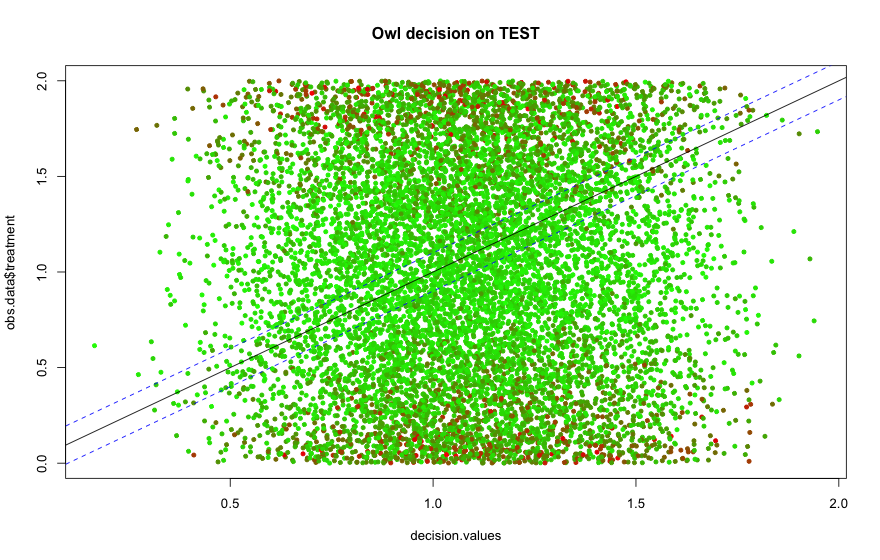

In [465]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on TEST")